In [1]:
import os 
import random
import numpy as np
import pandas as pd
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dropout, Flatten, MaxPooling2D, ZeroPadding2D, Dense, Activation, Conv2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils

from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


In [2]:
train_path = "../Dataset/train/"
test_path = "../Dataset/test/"

animal_class = ["CAT", "DOG"]

width = 64  
height = 64
channels = 3

In [3]:
# load images from folders
def get_images(fish):
    fish_dir = train_path + "{}".format(fish)
    images = [fish + '/' + im for im in os.listdir(fish_dir)]
    return images

# read and resize images
def read_image(src):
    im = imread(src)
    im = imresize(im, (width, height))
    return im

In [4]:
files = []
y_all = []

for animal in animal_class:
    animal_files = get_images(animal)
    files.extend(animal_files)
    
    y_animal = np.tile(animal, len(animal_files))
    y_all.extend(y_animal)
    print("There are {0} photos of {1}".format(len(animal_files), animal))
    
y_all = np.array(y_all)

There are 12500 photos of CAT
There are 12500 photos of DOG


In [5]:
X_all = np.ndarray((len(files), width, height, channels), dtype=np.float32)

for i, im in enumerate(files): 
    X_all[i] = read_image(train_path + im)
    
    if i%1000 == 0: 
        print("Processed {0} of {1} images".format(i, len(files)))

print(X_all.shape)

Processed 0 of 25000 images
Processed 1000 of 25000 images
Processed 2000 of 25000 images
Processed 3000 of 25000 images
Processed 4000 of 25000 images
Processed 5000 of 25000 images
Processed 6000 of 25000 images
Processed 7000 of 25000 images
Processed 8000 of 25000 images
Processed 9000 of 25000 images
Processed 10000 of 25000 images
Processed 11000 of 25000 images
Processed 12000 of 25000 images
Processed 13000 of 25000 images
Processed 14000 of 25000 images
Processed 15000 of 25000 images
Processed 16000 of 25000 images
Processed 17000 of 25000 images
Processed 18000 of 25000 images
Processed 19000 of 25000 images
Processed 20000 of 25000 images
Processed 21000 of 25000 images
Processed 22000 of 25000 images
Processed 23000 of 25000 images
Processed 24000 of 25000 images
(25000, 64, 64, 3)


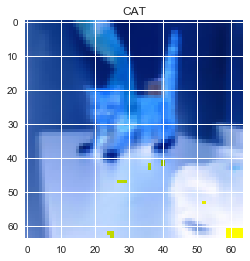

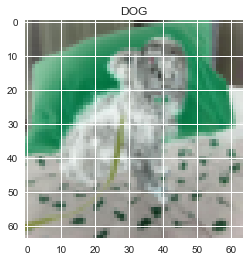

In [6]:
# display animals from each class
uniq = np.unique(y_all, return_index=True)

for f, i in zip(uniq[0], uniq[1]):
    plt.imshow(X_all[i])
    plt.title(f)
    plt.show()

# Perform one-hot encoding

In [7]:
# One Hot Encoding Labels
y_all = LabelEncoder().fit_transform(y_all)
y_all = np_utils.to_categorical(y_all)

# Split into training and testing set

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=666)

In [9]:
# print("Shape of training set: {}".format(X_train.shape))
# print("Shape of testing set: {}".format(X_test.shape))
# print("")
# print("Shape of train label: {}".format(y_train.shape))
# print("Shape of test label: {}".format(y_test.shape))

In [10]:
# use full training set
X_train = X_all
y_train = y_all

In [11]:
print("Shape of testing set: {}".format(X_train.shape))
print("")
print("Shape of train label: {}".format(y_train.shape))

Shape of testing set: (25000, 64, 64, 3)

Shape of train label: (25000, 2)


# Design convolutional neural network

In [12]:
optimizer = RMSprop(lr=0.0001)
objective = "binary_crossentropy"

def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)

model = Sequential()

model.add(Activation(activation=center_normalize, input_shape=(width, height, channels)))

model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
# model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
# model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
# model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

# model.add(Dense(256, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(len(animal_class)))
model.add(Activation("sigmoid"))

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

In [13]:
## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

In [14]:
history = LossHistory()

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto') 

model.fit(X_train, y_train, 
          batch_size=64, 
          epochs=10, 
          validation_split=0.3, 
          verbose=1, 
          shuffle=True, 
          callbacks=[history, early_stopping])

Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 462s - loss: 0.6034 - acc: 0.7107 - val_loss: 1.4096 - val_acc: 0.0000e+00

In [15]:
# prediction = model.predict(X_test, verbose=1)
# print("Validation Log Loss: {}".format(log_loss(y_test, prediction)))

# Predict test set

In [16]:
test_files = [im for im in os.listdir(test_path)]

test = np.ndarray((len(test_files), width, height, channels), dtype=np.float32)

for i, im in enumerate(test_files): 
    test[i] = read_image(test_path + im)
    
test_preds = model.predict(test, verbose=1)

12500/12500 [==============================] - 114s     

# Submission to Kaggle

In [32]:
dog_prediction = test_preds[0:, 1]

submission = pd.DataFrame(dog_prediction)
submission.insert(0, "id", test_files)
submission.head()

,id,0
0,1.jpg,0.103615
1,10.jpg,0.056229
2,100.jpg,0.003090
3,1000.jpg,0.124855
4,10000.jpg,0.092408


In [33]:
# submission.to_csv("cats_dogs_result_v1.csv")